# Table of Contents

- [Libraries](#Libraries)
- [Data](#Data)
- [Multicolinearity](#Multicolinearity-VIF)
    - [Heatmap](#Heatmap)
- [Modeling](#Modeling)
    * [Standardize Data](#Standardize-Data)
    * [PCA](#PCA)
    - [K-Means](#K-Means)
    * [Clustering](#Clustering)

# Libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans, k_means
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
from scipy.spatial.distance import cdist
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
pitch_data = pd.read_csv('../datasets/mlb_pitch_stats_19_20_21.csv', index_col= ['player_id'])
pitch_data.drop(columns = ['Unnamed: 0',' first_name', 'last_name'], axis = 1, inplace = True)
print(pitch_data.shape)
pitch_data.head()

(1072, 86)


,year,age,ip,bf,ab,h,k%,bb%,ba,slg%,...,cb_brk,cb_velo_range,cu%,cu_velo,cu_spinrate,cu_hb,cu_vb,cu_brk,cu_velo_range,xops
player_id,,,,,,,,,,,,,,,,,,,,,
425794,2021,40,196.1,784,725,157,21.6,5.9,0.217,0.343,...,22.3,1.6,22.2,85.0,2408.0,6.3,-31.0,9.5,1.6,0.681
425844,2021,38,164.2,670,626,157,17.0,5.2,0.251,0.431,...,15.6,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.725
429722,2021,39,61.1,255,232,58,18.8,7.5,0.250,0.444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.851
433589,2021,37,72.1,290,273,63,12.4,4.1,0.231,0.399,...,10.7,1.8,23.3,84.5,2133.0,-1.1,-21.1,17.3,1.3,0.722
445276,2021,34,61.2,250,210,33,29.6,13.6,0.157,0.233,...,0.0,0.0,57.1,92.5,2689.0,7.3,-14.4,19.2,1.9,0.570


# Multicolinearity - VIF

In [3]:
vif_data = pd.DataFrame()
vif_data["feature"] = pitch_data.columns

vif_data["VIF"] = [variance_inflation_factor(pitch_data.values, i)
                          for i in range(len(pitch_data.columns))]

vif_data.sort_values(by = 'VIF').head(20)

,feature,VIF
15,cg,1.364100
1,age,1.365355
81,cu_hb,1.527192
41,edge%,1.624982
29,solid_contact%,1.835575
30,poor_weak%,2.339208
60,sl_hb,2.433292
64,ch%,2.848569
74,cb_hb,2.861837
56,4seam_velo_range,2.870094


In [4]:
X = pitch_data[['age', 'edge%', 'poor_weak%', '4seam%', 
                '4seam_velo', 'ch%', 'cb%', 'sl%', 'cu%']]
print(X.shape)
X.head()

(1072, 9)


,age,edge%,poor_weak%,4seam%,4seam_velo,ch%,cb%,sl%,cu%
player_id,,,,,,,,,
425794,40,44.8,3.2,9.3,89.1,6.3,34.5,0.0,22.2
425844,38,42.8,5.0,40.1,89.0,21.9,16.7,15.5,0.0
429722,39,40.1,4.8,45.3,93.4,3.2,0.0,51.5,0.0
433589,37,43.3,6.6,45.1,87.6,18.1,13.5,0.0,23.3
445276,34,40.9,11.5,0.0,0.0,0.0,0.0,15.5,57.1


### Heatmap

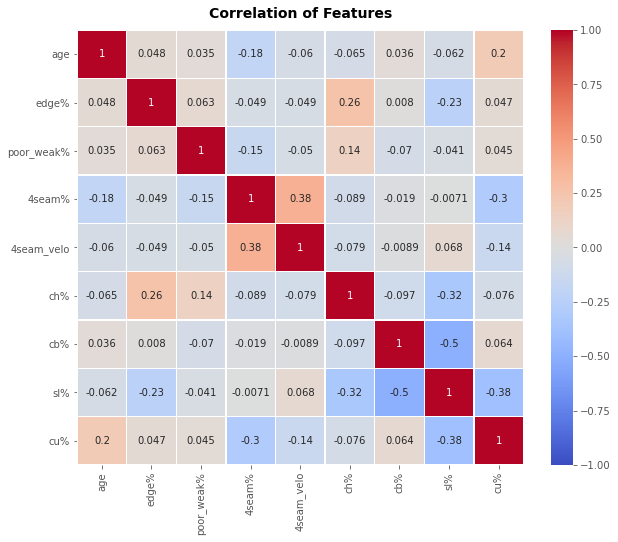

In [5]:
plt.figure(figsize = (10, 8))
sns.heatmap(X.corr(), annot = True,
            vmin = -1, 
            vmax = 1,
            linewidths = 0.5,
            cmap = 'coolwarm')
plt.title('Correlation of Features', 
          fontsize = 14, fontweight = 'bold', 
          pad = 12);

#plt.savefig('heatmap.png')

# Modeling

## Standardize Data

In [6]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X)

X_scaled[:,:] *= -1

## PCA

In [7]:
pca = PCA().fit(X_scaled)
principal_components = pca.transform(X_scaled)

[0.21694105 0.16203044 0.14960402 0.10897474 0.10234298 0.08906305
 0.08014498 0.06656694 0.02433182]


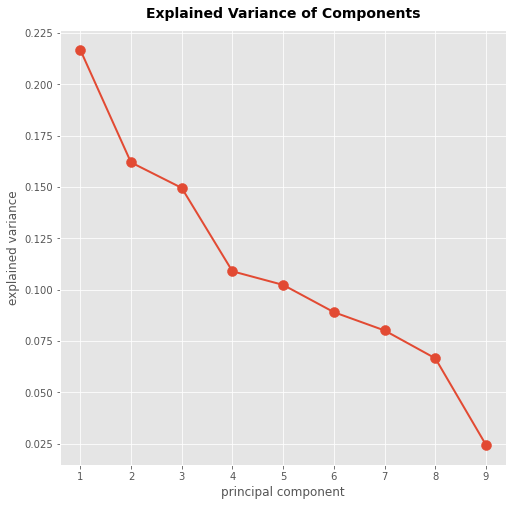

In [8]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(range(1, 10), pca.explained_variance_ratio_, lw = 2)
ax.scatter(range(1, 10), pca.explained_variance_ratio_, s = 100)
ax.set_title('Explained Variance of Components', fontsize = 14, 
             fontweight = 'bold', pad = 12)
ax.set_xlabel('principal component', fontsize = 12)
ax.set_ylabel('explained variance', fontsize = 12);
print(pca.explained_variance_ratio_)

#plt.savefig('explained varience ratio.png')

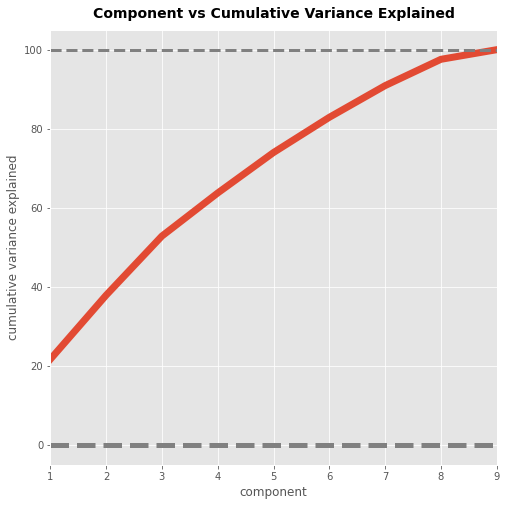

In [9]:
cum_var_exp = np.cumsum(pca.explained_variance_ratio_) * 100
plt.figure(figsize=(8,8))
component_number = range(1, 10)
plt.plot(component_number, cum_var_exp, lw = 7)
plt.axhline(y = 0, linewidth = 5, color = 'grey', ls = 'dashed')
plt.axhline(y = 100, linewidth = 3, color = 'grey', ls = 'dashed')
ax = plt.gca()
ax.set_xlim([1, 9], auto = True)
ax.set_ylim([-5,105])
ax.set_ylabel('cumulative variance explained', fontsize = 12)
ax.set_xlabel('component', fontsize = 12)  
ax.set_title('Component vs Cumulative Variance Explained', 
             fontsize = 14, fontweight = 'bold', pad = 12);

#plt.savefig('component v. cumulative variance explained.png')

source: https://git.generalassemb.ly/dsir-712/pca/blob/master/starter-code-Sophie.ipynb

In [10]:
pitch_df = pd.DataFrame(data = principal_components, 
                        columns = X.columns)

print(pitch_df.shape)
pitch_df.head()

(1072, 9)


,age,edge%,poor_weak%,4seam%,4seam_velo,ch%,cb%,sl%,cu%
0,2.934779,-0.120164,-2.016951,-1.430053,-1.031787,-1.638736,-0.026824,-0.638371,-0.198306
1,0.870585,-0.021394,0.139578,-1.377957,-0.415924,-1.793754,1.245117,0.367308,-0.399114
2,-1.641256,1.962919,-0.859741,-1.960721,-0.399781,-1.394553,0.949191,0.651291,-0.588225
3,1.984921,-0.116707,-0.141095,-1.889957,0.212770,-0.412625,0.740203,1.050551,-0.256455
4,3.867398,4.882333,-0.765574,0.422038,1.863744,0.763246,-0.781254,3.121196,-0.448082


## K-Means

In [11]:
inertias = []
mapping = {}
K = range(1, 10)
 
for k in K:
    km = KMeans(n_clusters=k).fit(X_scaled)
    km.fit(X_scaled)
 
    inertias.append(km.inertia_)

    mapping[k] = km.inertia_

In [12]:
# inertia
for key, val in mapping.items():
    print(f'{key} : {val}')

1 : 9648.000000000016
2 : 8266.514178524325
3 : 7159.846739222604
4 : 6438.784836489976
5 : 5852.949561314954
6 : 5465.445371948432
7 : 5216.189889528173
8 : 5028.9113544610245
9 : 4837.966242586462


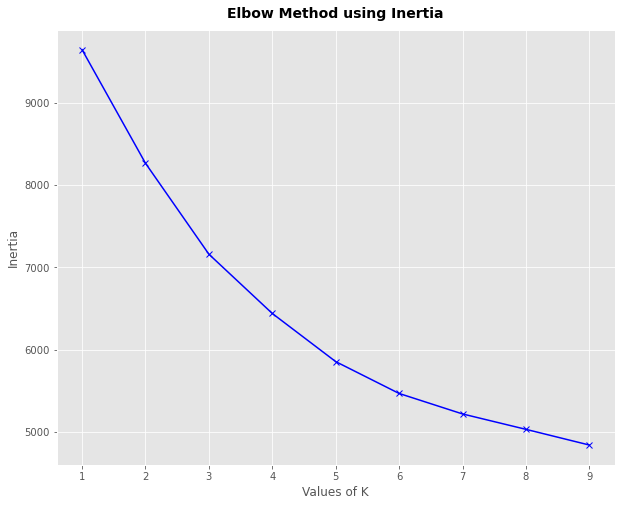

In [13]:
plt.figure(figsize = (10,8))

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K', fontsize = 12)
plt.ylabel('Inertia', fontsize = 12)
plt.title('Elbow Method using Inertia', fontsize = 14, fontweight = 'bold', pad = 12);

#plt.savefig('elbow method for clusters.png')

source: #https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

In [14]:
km = KMeans(n_clusters = 4,
            random_state = 0)

km.fit(pitch_df)
label = km.fit_predict(pitch_df)

print(label)

[0 3 1 ... 3 1 1]


In [15]:
print('label:', km.labels_)
print('Number of iterations:', km.n_iter_)
print('Number of features:', km.n_features_in_)
print('Number of clusters:', km.n_clusters)
print('Inertia:', km.inertia_)
print('Silhouette Score:', silhouette_score(pitch_df, label))

label: [0 3 1 ... 3 1 1]
Number of iterations: 28
Number of features: 9
Number of clusters: 4
Inertia: 6459.974698250469
Silhouette Score: 0.14862595565220646


In [16]:
centroids = km.cluster_centers_
print("Predicted clusters to points: ", label[:10], '\n')
print('Location of centroids:', '\n')
print(centroids)

Predicted clusters to points:  [0 3 1 0 2 0 0 0 3 0] 

Location of centroids: 

[[ 1.51410035  0.08189897 -0.83312628 -0.64766176  0.03263226  0.48950671
   0.05073162 -0.21859956  0.04419626]
 [-1.21738043  0.58470773 -0.08609578 -0.09678767 -0.00860153 -0.05991749
  -0.05500572 -0.09504172 -0.0042859 ]
 [ 2.5973847   2.80234131  0.24087732  2.86995364 -0.57201542 -0.64918665
  -0.27979785  1.78623618 -0.02408892]
 [ 0.15321078 -0.92899635  0.50035585  0.13492061  0.05204775 -0.1288994
   0.05830562  0.02178378 -0.0164267 ]]


In [17]:
cen_age = centroids[:, 0]
print('age:', cen_age, '\n')
cen_edge = centroids[:, 1]
print('edge:', cen_edge, '\n')
cen_poor_weak = centroids[:, 2]
print('poor_weak:', cen_poor_weak, '\n')
cen_4seam_pct = centroids[:, 3]
print('4seam%:', cen_4seam_pct, '\n')
cen_4seam_velo = centroids[:, 4]
print('4seam_velo:', cen_4seam_velo, '\n')
cen_ch_pct = centroids[:, 5]
print('ch%:', cen_ch_pct, '\n')
cen_cb_pct = centroids[:, 6]
print('cb%:', cen_cb_pct, '\n')
cen_sl_pct = centroids[:, 7]
print('sl%:', cen_sl_pct, '\n')
cen_cu_pct = centroids[:, 8]
print('cu%:', cen_cu_pct, '\n')

age: [ 1.51410035 -1.21738043  2.5973847   0.15321078] 

edge: [ 0.08189897  0.58470773  2.80234131 -0.92899635] 

poor_weak: [-0.83312628 -0.08609578  0.24087732  0.50035585] 

4seam%: [-0.64766176 -0.09678767  2.86995364  0.13492061] 

4seam_velo: [ 0.03263226 -0.00860153 -0.57201542  0.05204775] 

ch%: [ 0.48950671 -0.05991749 -0.64918665 -0.1288994 ] 

cb%: [ 0.05073162 -0.05500572 -0.27979785  0.05830562] 

sl%: [-0.21859956 -0.09504172  1.78623618  0.02178378] 

cu%: [ 0.04419626 -0.0042859  -0.02408892 -0.0164267 ] 



In [18]:
X['label'] = label
pitch_data['label'] = label
pitch_df['label'] = label
pitch_df.head()

,age,edge%,poor_weak%,4seam%,4seam_velo,ch%,cb%,sl%,cu%,label
0,2.934779,-0.120164,-2.016951,-1.430053,-1.031787,-1.638736,-0.026824,-0.638371,-0.198306,0
1,0.870585,-0.021394,0.139578,-1.377957,-0.415924,-1.793754,1.245117,0.367308,-0.399114,3
2,-1.641256,1.962919,-0.859741,-1.960721,-0.399781,-1.394553,0.949191,0.651291,-0.588225,1
3,1.984921,-0.116707,-0.141095,-1.889957,0.212770,-0.412625,0.740203,1.050551,-0.256455,0
4,3.867398,4.882333,-0.765574,0.422038,1.863744,0.763246,-0.781254,3.121196,-0.448082,2


In [19]:
pitch_df.groupby(by = 'label').mean().T

label,0,1,2,3
age,1.514100,-1.217380,2.597385,0.153211
edge%,0.081899,0.584708,2.802341,-0.928996
poor_weak%,-0.833126,-0.086096,0.240877,0.500356
4seam%,-0.647662,-0.096788,2.869954,0.134921
4seam_velo,0.032632,-0.008602,-0.572015,0.052048
ch%,0.489507,-0.059917,-0.649187,-0.128899
cb%,0.050732,-0.055006,-0.279798,0.058306
sl%,-0.218600,-0.095042,1.786236,0.021784
cu%,0.044196,-0.004286,-0.024089,-0.016427


In [20]:
X.groupby(by = 'label').mean().T

label,0,1,2,3
age,31.640187,28.804401,29.325581,27.807882
edge%,42.743925,41.517848,42.683721,43.198276
poor_weak%,4.418692,4.068704,4.674419,4.273153
4seam%,22.335981,37.001467,0.000000,43.776108
4seam_velo,92.323832,94.019560,0.000000,93.181527
ch%,9.400467,5.733496,13.372093,16.633744
cb%,14.952804,4.388753,10.134884,14.641872
sl%,4.824299,33.200978,14.762791,10.716749
cu%,26.403738,0.927139,15.265116,2.624877


In [21]:
X2 = pitch_data[['age', 'edge%', 'poor_weak%', '4seam%', 
                 '4seam_velo', 'ch%', 'sl%','cu%', 'cb%', 'throws']]

X2['label'] = label
X2.groupby(by = 'label').mean().T

label,0,1,2,3
age,31.640187,28.804401,29.325581,27.807882
edge%,42.743925,41.517848,42.683721,43.198276
poor_weak%,4.418692,4.068704,4.674419,4.273153
4seam%,22.335981,37.001467,0.000000,43.776108
4seam_velo,92.323832,94.019560,0.000000,93.181527
ch%,9.400467,5.733496,13.372093,16.633744
sl%,4.824299,33.200978,14.762791,10.716749
cu%,26.403738,0.927139,15.265116,2.624877
cb%,14.952804,4.388753,10.134884,14.641872
throws,0.677570,0.789731,0.534884,0.701970


## Clustering

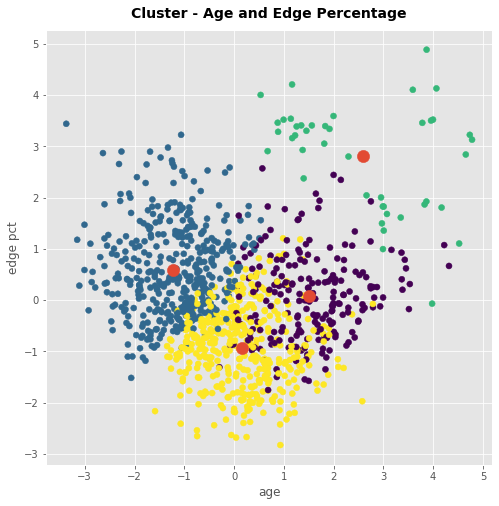

In [22]:
plt.figure(figsize = (8, 8))

plt.scatter(pitch_df['age'], pitch_df['edge%'], 
            c = pitch_df['label']);
plt.scatter(cen_age, 
            cen_edge, 
            marker = 'o', s = 150)
plt.xlabel('age', fontsize = 12)
plt.ylabel('edge pct', fontsize = 12)
plt.title('Cluster - Age and Edge Percentage', 
          fontsize = 14, fontweight = 'bold', 
          pad = 12);

#plt.savefig('age and edge pct cluster.png')

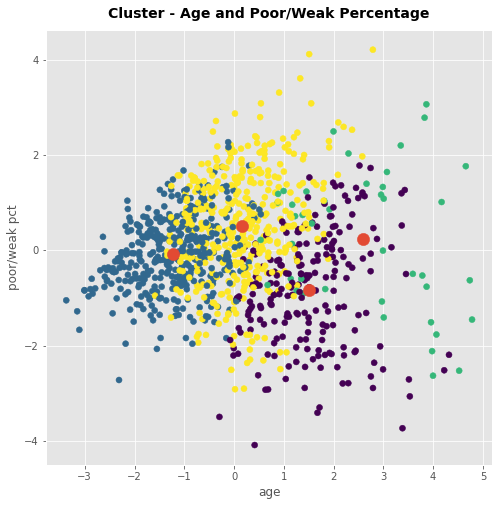

In [23]:
plt.figure(figsize = (8, 8))

plt.scatter(pitch_df['age'], pitch_df['poor_weak%'], 
            c = pitch_df['label']);
plt.scatter(cen_age, 
            cen_poor_weak, 
            marker = 'o', s = 150)
plt.xlabel('age', fontsize = 12)
plt.ylabel('poor/weak pct', fontsize = 12)
plt.title('Cluster - Age and Poor/Weak Percentage', 
          fontsize = 14, fontweight = 'bold', 
          pad = 12);

#plt.savefig('age and poor_weak contact cluster.png')

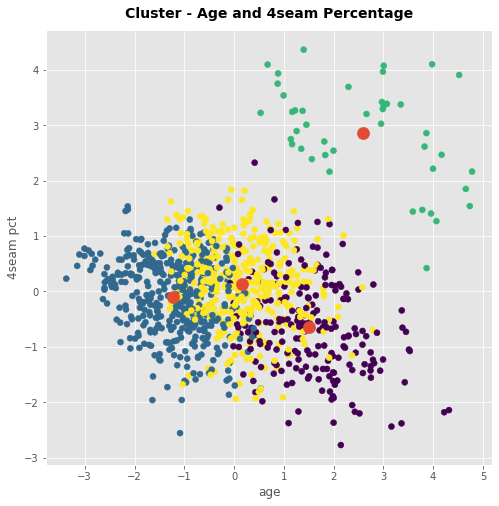

In [24]:
plt.figure(figsize = (8, 8))

plt.scatter(pitch_df['age'], pitch_df['4seam%'], 
            c = pitch_df['label']);
plt.scatter(cen_age, 
            cen_4seam_pct, 
            marker = 'o', s = 150)
plt.xlabel('age', fontsize = 12)
plt.ylabel('4seam pct', fontsize = 12)
plt.title('Cluster - Age and 4seam Percentage', 
          fontsize = 14, fontweight = 'bold', 
          pad = 12);

#plt.savefig('age and 4seam pct cluster.png')

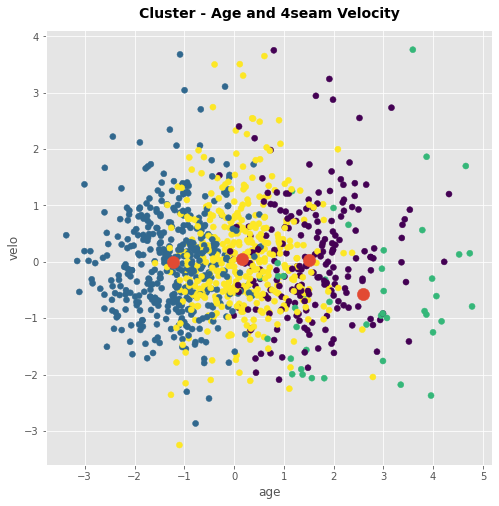

In [25]:
plt.figure(figsize = (8, 8))

plt.scatter(pitch_df['age'], pitch_df['4seam_velo'], 
            c = pitch_df['label']);
plt.scatter(cen_age, 
            cen_4seam_velo, 
            marker = 'o', s = 150)
plt.xlabel('age', fontsize = 12)
plt.ylabel('velo', fontsize = 12)
plt.title('Cluster - Age and 4seam Velocity', 
          fontsize = 14, fontweight = 'bold', 
          pad = 12);

#plt.savefig('age and 4seam velo cluster.png')

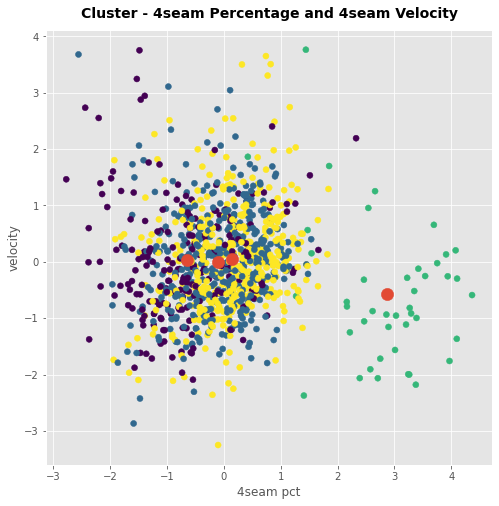

In [26]:
plt.figure(figsize = (8, 8))

plt.scatter(pitch_df['4seam%'], pitch_df['4seam_velo'], 
            c = pitch_df['label']);
plt.scatter(cen_4seam_pct, 
            cen_4seam_velo, 
            marker = 'o', s = 150)
plt.xlabel('4seam pct', fontsize = 12)
plt.ylabel('velocity', fontsize = 12)
plt.title('Cluster - 4seam Percentage and 4seam Velocity',
          fontsize = 14, fontweight = 'bold', 
          pad = 12);

#plt.savefig('4seam pct and 4seam velo cluster.png')